In [1]:
import pandas as pd
import ast

In [45]:
ft=pd.read_csv("comb.csv")["title"].apply(strip)
ft=list(ft)
ss=list(pd.read_csv("semantic.csv")["title"].apply(strip))
ft.extend(ss)


In [2]:
df=pd.read_csv("full_meta.csv")

In [28]:
df["title"]=df["title"].str.lower()

In [29]:
df=df.drop_duplicates(["title"])

In [30]:
import re
def strip(s):
    s=' '.join(s.split())
    return re.sub(r'[^A-Za-z0-9 ]+', '', s).lower()

In [31]:
def conv(s):
    try:
        return ast.literal_eval(s)
    except:
        return s

In [32]:
df=df[df["date"]!="Preview"]
df=df[df["date"]!="Editorial"]
df=df[df["date"]!='dhqinfo@digitalhumanities.org']

In [33]:
from datetime import datetime

In [34]:
def tdt(s):
    try:
        return s.to_pydatetime()
    except:
        return s

In [35]:
df["date"]=df["date"].apply(tdt)

In [36]:
df=df.dropna(subset=["date"])

In [37]:
date=[]
for d in df["date"]:
    try:
        date.append(pd.to_datetime(d))
    except:
        #print(d)
        date.append(datetime.strptime(d, "%Y %d.%m"))

In [38]:
df["date"]=date

In [39]:
df=df.reset_index()

In [40]:
df["text"]=df["text"].fillna("").apply(strip)

In [41]:
df["date"]=pd.to_datetime(df["date"], utc=True)

In [43]:
df["year"]=df["date"].dt.year

In [47]:
has_ft=[]
for t in df["title"]:
    if t in ft:
        has_ft.append(1)
    else:
        has_ft.append(0)

In [49]:
df["has_ft"]=has_ft

In [50]:
goog=[]
ngram=[]
for i,row in df.iterrows():
    t=row["text"]
    has_ft=row["has_ft"]
    if "google" in t:
        if "ngram" in t or "n-gram" in t:
            ngram.append(1)
            goog.append(0)
        #elif "google book" in t:
        elif "google book" in t:
            goog.append(1)
            ngram.append(0)
        elif has_ft==0:
            if "books" in t:
                goog.append(1)
                ngram.append(0)
            else:
                ngram.append(0)
                goog.append(0)
        else:
            ngram.append(0)
            goog.append(0)
    else:
        goog.append(0)
        ngram.append(0)

In [51]:
hathi=[]
for i in range(0,len(df["text"])):
    t=df["text"][i]
    yr=df["year"][i]
    has_ft=df["has_ft"][i]
    if yr<2006:
        hathi.append(0)
        continue
    if "hathi trust" in t or "hathitrust" in t:
        hathi.append(1)
    elif has_ft==0 and "hathi" in t and "trust" in t:
        hathi.append(1)
    else:
        hathi.append(0)

In [52]:
ia=[]
for t in df["text"]:
    if "internet archive" in t or "archiveorg" in t:
    #if "internet" in t and "archive" in t:
        ia.append(1)
    else:
        ia.append(0)

In [53]:
gute=[]
for i,row in df.iterrows():
    t=row["text"]
    has_ft=row["has_ft"]
    if "project gutenberg" in t:
        gute.append(1)
    elif has_ft==0:
        if "gutenberg" in t:
            gute.append(1)
        else:
            gute.append(0)
    else:
        gute.append(0)

In [54]:
df["goog"]=goog
df["goog ngram"]=ngram
df["hathi"]=hathi
df["ia"]=ia
df["gute"]=gute

In [55]:
df=df[df[["goog", "goog ngram", "hathi", "ia", "gute"]].sum(axis=1)>0]

In [56]:
temp=df[["goog", "hathi", "ia", "gute", "goog ngram"]].groupby(df["date"].dt.year).sum()
temp=temp[temp.index>2000]
temp=temp[temp.index<2023]

In [57]:
temp["sum"]=temp.sum(axis=1)
temp["goog"]=temp["goog"]/temp["sum"]
temp["goog ngram"]=temp["goog ngram"]/temp["sum"]

temp["hathi"]=temp["hathi"]/temp["sum"]
temp["ia"]=temp["ia"]/temp["sum"]
temp["gute"]=temp["gute"]/temp["sum"]

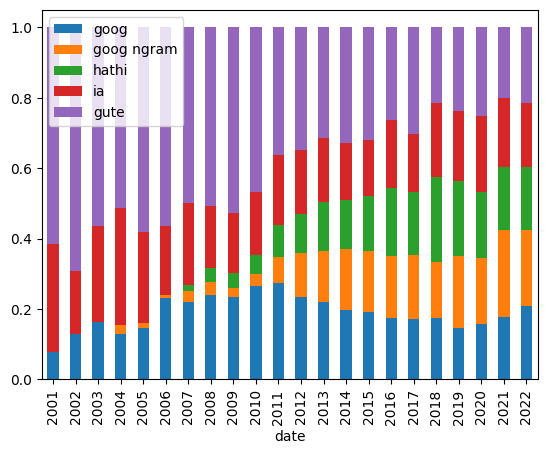

In [58]:
temp[["goog","goog ngram", "hathi", "ia", "gute", ]].plot(kind="bar", stacked=True).legend(loc='upper left')


In [59]:
df=df[df["year"]>2000]
df=df[df["year"]<2023]


<Axes: xlabel='date'>

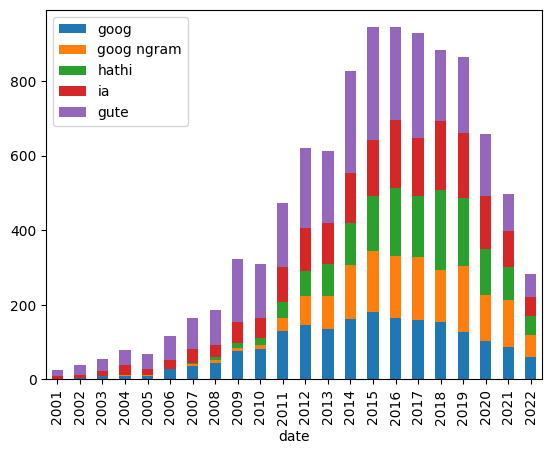

In [60]:
df[["goog","goog ngram", "hathi", "ia", "gute"]].groupby(df["date"].dt.year).sum().plot(kind="bar", stacked=True,)

In [61]:
year_ct=pd.read_csv("results-overview.csv")

In [62]:
year_ct=year_ct.set_index("year")

In [63]:
temp=df[["goog", "hathi", "ia", "gute", "goog ngram"]].groupby(df["date"].dt.year).sum()
temp=temp[temp.index>2000]
temp=temp[temp.index<2023]

In [64]:
temp=temp[temp.index>1999]
temp=temp[temp.index<2023]

In [65]:
temp["goog"]=temp["goog"]/year_ct["documents"]
temp["goog ngram"]=temp["goog ngram"]/year_ct["documents"]
temp["hathi"]=temp["hathi"]/year_ct["documents"]
temp["ia"]=temp["ia"]/year_ct["documents"]
temp["gute"]=temp["gute"]/year_ct["documents"]

<Axes: xlabel='date'>

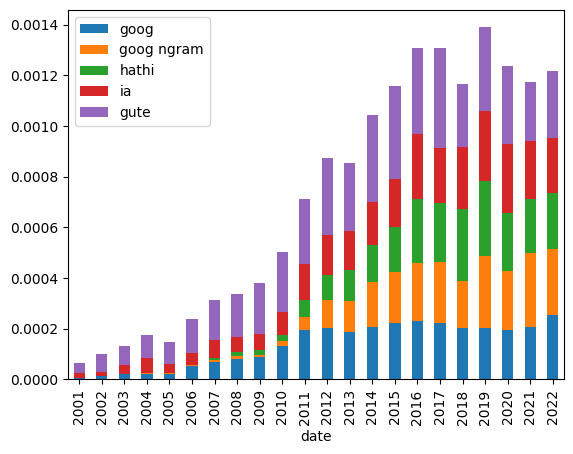

In [67]:
temp[["goog","goog ngram", "hathi", "ia", "gute", ]].plot(kind="bar", stacked=True,)

In [68]:
genre_scores=pd.read_csv("subj.csv")

In [69]:
genre_scores["title"]=genre_scores["title"].str.lower()

In [70]:
genre_scores=genre_scores.set_index("title")

In [71]:
gs=genre_scores.T

In [72]:
def cutoff(s):
    if s<0.6:
        return 0
    else:
        return s

In [73]:
filt=genre_scores.applymap(cutoff)

In [74]:
filt[filt["biological sciences"]>0.8]

,arts,philosophy,literature,applied philosophy,information science,computer science,social sciences,education,medicine,biology,...,educational psychology,philosophy of language,the humanities,bibliography,axiology,chemistry,industry,mathematical objects,judicial system,technology
title,,,,,,,,,,,,,,,,,,,,,
bibliography,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.951027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
on the original author and year of description of the extinct hyaenid pachycrocuta brevirostris,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.931406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total knowledge? encyclopedic handbooks in the twentieth-century chemical and life sciences,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.902266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
punnett squares and hybrid crosses: how mendelians learned their trade by the book,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.915228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fourier and agriculture,0.0,0.880141,0.0,0.943695,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
facts and arguments for darwin,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.804345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
national environmental policy 2013 adaptation strategies for sustainability of samburu pastoral community in samburu central subcounty kenya,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
from bioblasts to mitochondria ever expanding roles of mitochondria in cell physiology,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.743624,0.990152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
subj=pd.DataFrame()

In [76]:
df=pd.read_csv("full_meta.csv")

In [77]:
temp=df[df["goog"]==1].iloc[:, 5:-7]
subj["google books"]=temp.sum()

In [78]:
temp=df[df["goog ngram"]==1].iloc[:, 5:-7]
subj["google ngram"]=temp.sum()

In [79]:
temp=df[df["hathi"]==1].iloc[:, 5:-7]
subj["HathiTrust"]=temp.sum()

In [80]:
temp=df[df["ia"]==1].iloc[:, 5:-7]
subj["internet archive"]=temp.sum()

In [81]:
temp=df[df["gute"]==1].iloc[:, 5:-7]
subj["project gutenberg"]=temp.sum()

In [82]:
subj=subj[subj.sum(axis=1)>500]

In [84]:
temp=df.iloc[:, 5:-7]

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

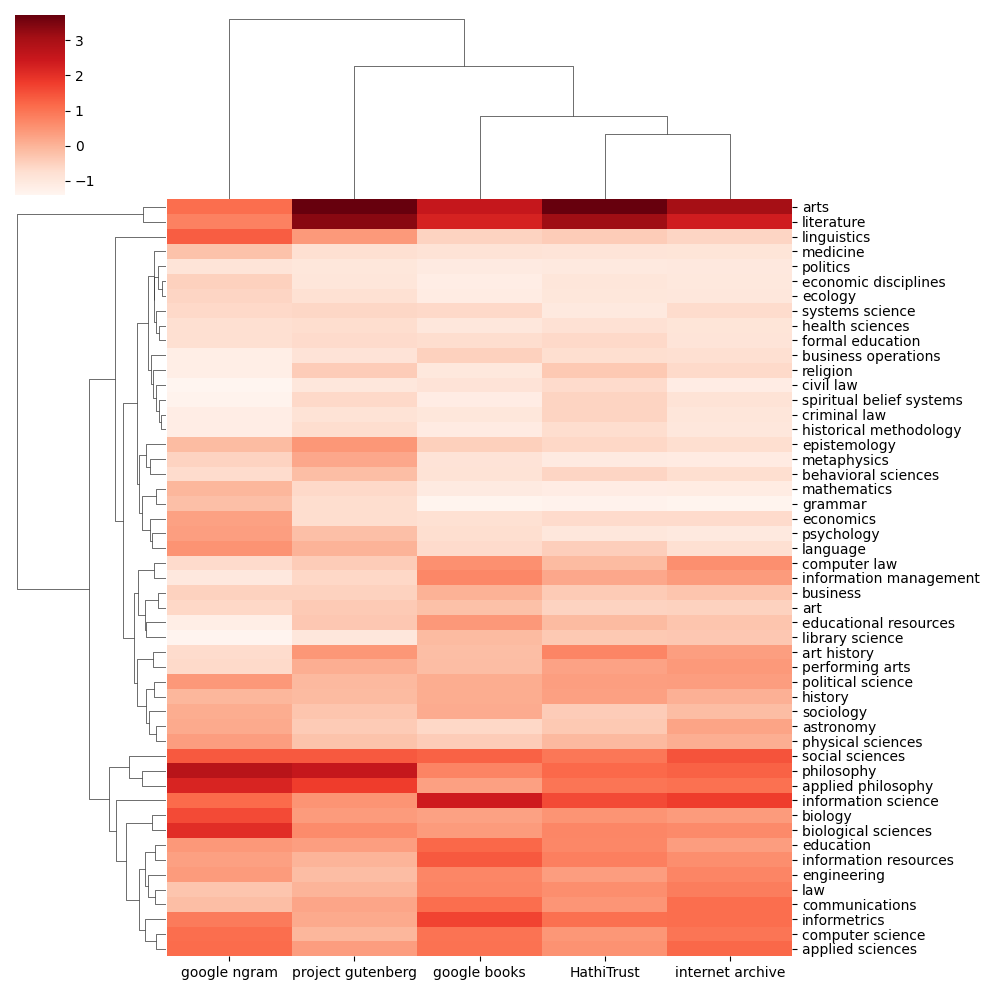

In [86]:
sns.clustermap(subj, z_score=1, yticklabels=True, cmap="Reds")


In [87]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import fcluster


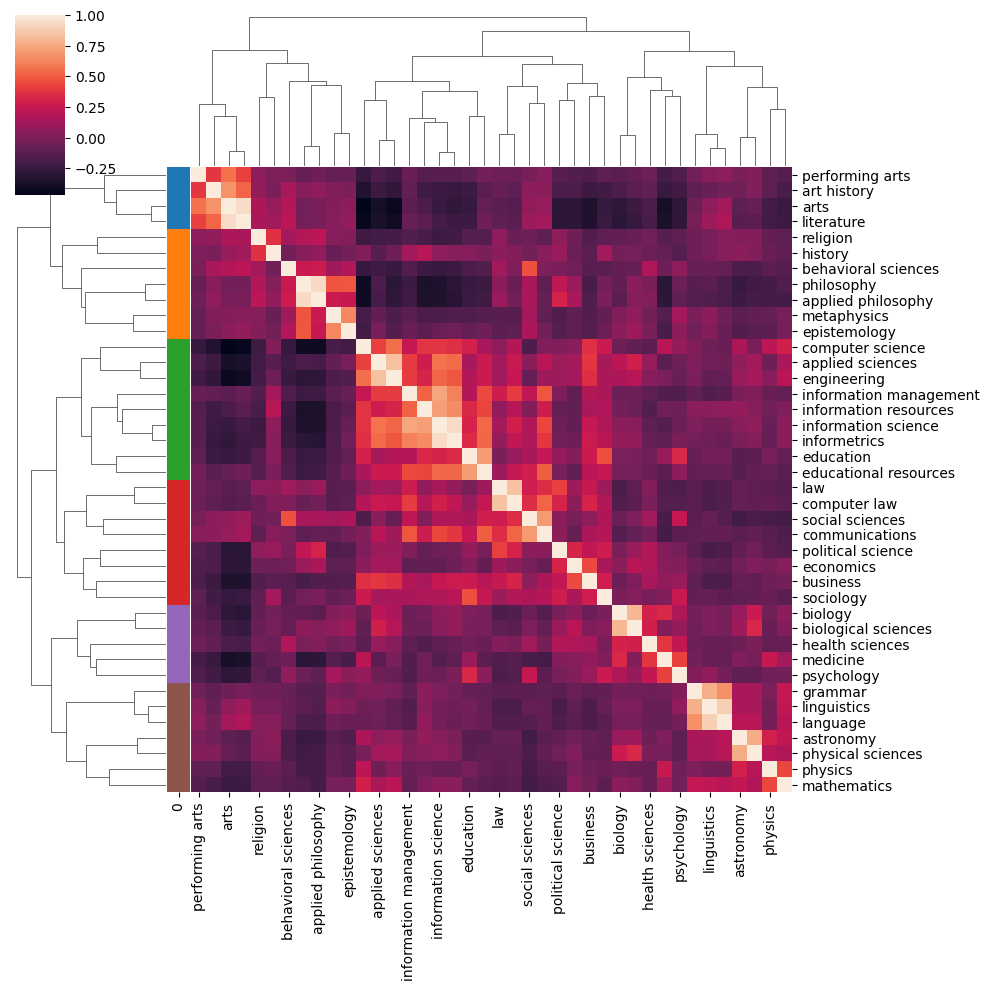

In [89]:
corr_matrix = genre_scores.iloc[:, : 40].corr()
Z = linkage(corr_matrix, 'average')
clust=fcluster(Z, 6, criterion='maxclust')
labels = clust
lut = dict(zip(set(labels), sns.color_palette()))
row_colors = pd.DataFrame(labels)[0].map(lut)
row_colors.index=corr_matrix.index 
sns.clustermap(corr_matrix, yticklabels=True, row_colors=row_colors)
plt.show()

<Axes: >

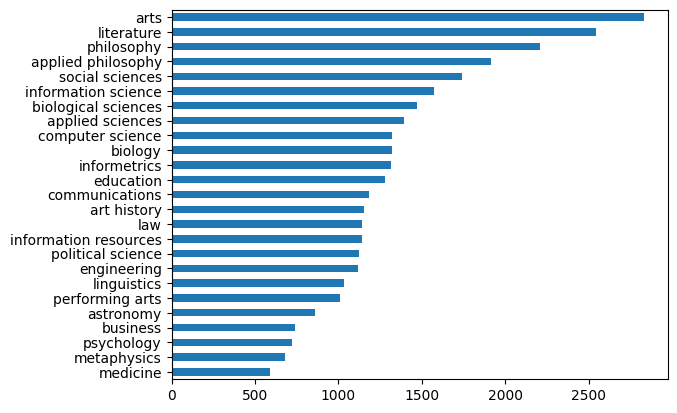

In [90]:
temp.sum().head(25).sort_values(ascending=True).plot.barh()

In [91]:
subjs=["literature", "philosophy", "social sciences", "biological sciences", "information science", "art history", "law", "psychology", "information resources", "linguistics", "applied sciences", "communications", "computer science"]

In [92]:
t=df[df["chemistry"]>0.8]

In [93]:
df.to_csv("full_meta.csv")

In [94]:
t[t["hathi"]==1]["text"].iloc[1]

'      like like   sirna launching buschmann phase group nanomaterials nanomaterials frame    title title international international international international international hwang httpsorcidorg  submissions p more more more more more more more more more more more more more more more more more more more more more more more more more more more more more more  supervision    section section section section section section section section  radial radial basic asked   derived derived completed too too    lucchesi lucchesi reuse older kallos region unsteadystate discussion  award award production clearly sustainable sustainable sustainable sustainable sustainable programming shu amundson   energy energy energy energy energy energy energy energy spain mckay  prominent prominent require require champagne sponsors sponsors curation curation jou contributing contributing contributing contributing contributing topics years years years years protein engineering means after after flow renewable r

In [101]:
out=pd.DataFrame()
for s in list(df.columns)[5:-7]:
    temp=df[df[s].astype(float)>0.75][["hathi","goog ngram","goog", "ia", "gute"]].sum()
    temp=temp/temp.sum()
    out[s]=temp

In [102]:
out

,arts,philosophy,literature,applied philosophy,information science,computer science,social sciences,education,medicine,biology,...,educational psychology,philosophy of language,the humanities,bibliography,axiology,chemistry,industry,mathematical objects,judicial system,technology
hathi,0.193098,0.088692,0.184948,0.106890,0.186029,0.134707,0.107251,0.157627,0.077586,0.125616,...,0.027027,0.019231,0.222222,0.166667,0.04,0.4,0.272727,0.029412,0.207547,0.000000
goog ngram,0.051356,0.198817,0.050172,0.212898,0.096324,0.191759,0.184290,0.115254,0.310345,0.236453,...,0.243243,0.250000,0.388889,0.095238,0.20,0.0,0.136364,0.147059,0.150943,0.151515
goog,0.178307,0.127864,0.187408,0.112191,0.301471,0.253566,0.176737,0.303390,0.215517,0.169951,...,0.202703,0.038462,0.333333,0.380952,0.02,0.2,0.204545,0.117647,0.188679,0.212121
ia,0.182416,0.138950,0.163305,0.174028,0.220588,0.301109,0.226586,0.130508,0.112069,0.172414,...,0.135135,0.134615,0.055556,0.357143,0.06,0.2,0.181818,0.323529,0.169811,0.242424
gute,0.394823,0.445676,0.414166,0.393993,0.195588,0.118859,0.305136,0.293220,0.284483,0.295567,...,0.391892,0.557692,0.000000,0.000000,0.68,0.2,0.204545,0.382353,0.283019,0.393939


<Axes: >

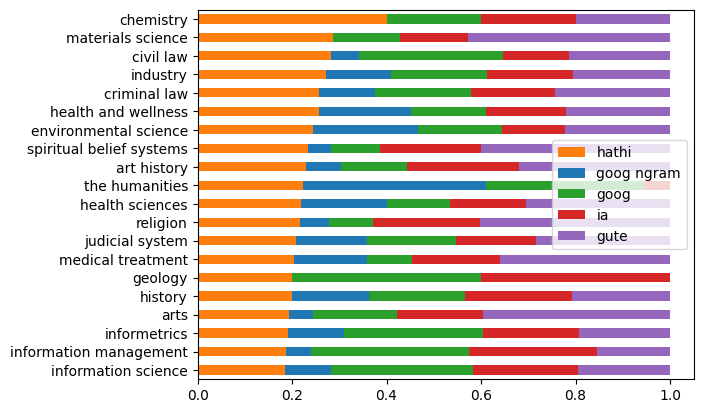

In [103]:
out.T.sort_values("hathi", ascending=True).tail(20).plot.barh(color=["C1", "C0", "C2", "C3", "C4"],stacked=True)

In [105]:
genre_scores = genre_scores[~genre_scores.index.duplicated(keep='first')]


In [106]:
df=df.set_index("title")

In [107]:
df=df[["date", "author", "text"]]

In [108]:
df=df.join(genre_scores)

In [110]:
gs["quantitative analysis of culture using millions of digitized books"].sort_values(ascending=False)

art                    0.843293
biological sciences    0.778669
biology                0.761438
cond-mat.stat-mech     0.613523
language               0.452312
                         ...   
judicial system        0.005806
metaphysics            0.005786
civil law              0.005218
axiology               0.003858
data products          0.003373
Name: quantitative analysis of culture using millions of digitized books, Length: 80, dtype: float64

In [111]:
df.to_csv("final.csv")